In [172]:
import numpy as np
import xarray as xr

import rasterio.features
import stackstac
import pystac_client
import planetary_computer

import xrspatial.multispectral as ms

from skimage.feature import graycomatrix, graycoprops
from skimage import data

# Sample data from [SandSnap](https://experience.arcgis.com/experience/f55871e51fcd4ae7a3a855e9f89a1f2a/page/Data-Viewer/?views=Photo%2CData-Viewer%2CAll-Details)

|ObjectID|lon|lat|D10 mm|	D16 mm|	D25 mm|	D50 mm|	D65 mm|	D75 mm|	D84 mm|	D90 mm|	DMEAN mm|
|----|----|----|----|----|----|----|----|----|----|----|----|
|925|0.255204176	|0.278472119	|0.307602216	|0.386369131	|0.437445286	|0.488720754	|0.556642596	|-89.04326197| 30.377676| 0.627979373	|0.389373062|
|92|-73.55689608|40.58032702|2.368180516	|2.583255884	|2.856032469	|3.595200869	|4.071484479	|4.549827805	|5.182148314	|5.848548026	|3.621642799|

In [220]:

lon, lat = -89.04326197, 30.377676
D50 = 0.386369131

#NY
lon, lat = -73.55689608, 40.58032702
D50 = 3.595200869

## Alt method

In [221]:
side_len_deg = 0.001

In [222]:
point_geom  = shapely.geometry.mapping(shapely.geometry.Point(lon, lat))
point_shape = shapely.geometry.shape(point_geom)
#Create a square out of it with side_length = buffer*2
mask_shape  = point_shape.buffer(side_len_deg/2.).envelope
aoi   = shapely.geometry.mapping(mask_shape)
bbox = rasterio.features.bounds(aoi)

In [223]:
bbox

(-73.55739608, 40.579827019999996, -73.55639608, 40.58082702)

Using pystac_client we can search the Planetary Computer's STAC endpoint for items matching our query parameters.

## TODO: Create a valid date range

In [224]:
stac = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)


range_date = "2018-01-01/2023-01-03"

search = stac.search(
    bbox=bbox,
    # intersects=aoi,
    datetime=range_date,
    collections=["naip"],
    limit=5,
    #query={"eo:cloud_cover": {"lt": 25}},
)

items = search.item_collection()
print(len(items))

1


In [225]:
items[0]

ID: ny_m_4007328_ne_18_060_20190809_20191209
"Bounding Box: [-73.566268, 40.559846, -73.496187, 40.627614]"
Datetime: 2019-08-09 00:00:00+00:00
gsd: 0.6
datetime: 2019-08-09T00:00:00Z
naip:year: 2019
"proj:bbox: [621378.0, 4490982.0, 627186.0, 4498410.0]"
proj:epsg: 26918
naip:state: ny
"proj:shape: [12380, 9680]"
"proj:transform: [0.6, 0.0, 621378.0, 0.0, -0.6, 4498410.0, 0.0, 0.0, 1.0]"


## Pick most appropriate NAIP tile
Sort them by area of coverage

In [226]:
from shapely.geometry import shape

area_shape = shape(aoi)
target_area = area_shape.area
# target_area = buffer.area


def area_of_overlap(item):
    overlap_area = shape(item.geometry).intersection(shape(aoi)).area
    return overlap_area / target_area


item = sorted(items, key=area_of_overlap, reverse=True)[0]

In [227]:
item.datetime

datetime.datetime(2019, 8, 9, 0, 0, tzinfo=tzutc())

In [228]:
item.properties

{'gsd': 0.6,
 'datetime': '2019-08-09T00:00:00Z',
 'naip:year': '2019',
 'proj:bbox': [621378.0, 4490982.0, 627186.0, 4498410.0],
 'proj:epsg': 26918,
 'naip:state': 'ny',
 'proj:shape': [12380, 9680],
 'proj:transform': [0.6, 0.0, 621378.0, 0.0, -0.6, 4498410.0, 0.0, 0.0, 1.0]}

In [229]:
item.assets['image']

href: https://naipeuwest.blob.core.windows.net/naip/v002/ny/2019/ny_60cm_2019/40073/m_4007328_ne_18_060_20190809.tif?st=2023-03-06T21%3A21%3A02Z&se=2023-03-14T21%3A21%3A03Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2023-03-07T21%3A21%3A01Z&ske=2023-03-14T21%3A21%3A01Z&sks=b&skv=2021-06-08&sig=TRZS/OCfVSO%2BzUB3ET9sYj5wsiBqCD%2BTWFeKmTddRGk%3D
Title: RGBIR COG tile
Media type: image/tiff; application=geotiff; profile=cloud-optimized
Roles: ['data']
Owner:
"eo:bands: [{'name': 'Red', 'common_name': 'red'}, {'name': 'Green', 'common_name': 'green'}, {'name': 'Blue', 'common_name': 'blue'}, {'name': 'NIR', 'common_name': 'nir', 'description': 'near-infrared'}]"


Extract resolution in m/px

In [232]:
gsd = item.properties['gsd'] 
gsd

0.6

Extract URL to actual RGB-NIR image

In [231]:
rgbir_url=item.assets['image'].href

Check CRS also

In [233]:
item.properties['proj:epsg']

26918

## Visualize the entire NAIP tile

In [234]:
from IPython.display import Image

Image(url=item.assets["rendered_preview"].href)

# Crop of AOI

Efficiently!

In [235]:
import shapely 
import rasterio
from rasterio.mask import mask

point_geom = shapely.geometry.mapping(shapely.geometry.Point(lon, lat))
PATCH_SIZE_M = 100.
# side_length_m = 101. #meters because the destination EPSG (26916) is in meters

with rasterio.Env():
    with rasterio.open(rgbir_url, "r") as f:
        point_geom = rasterio.warp.transform_geom(
            "epsg:4326", f.crs.to_string(), point_geom)

        #Convert the point to a shape
        point_shape = shapely.geometry.shape(point_geom)
        #Create a square out of it with side_length = buffer*2
        mask_shape = point_shape.buffer(PATCH_SIZE_M/2).envelope
        mask_geom = shapely.geometry.mapping(mask_shape)

        #crop to the aoi (mask)
        try:
            image_rgbir, _ = mask(
                f, [mask_geom], crop=True)
            
        except ValueError as e:
            if "Input shapes do not overlap raster." in str(e):
                print ("no dice")

4-channel numpy array

In [236]:
image_rgbir.shape

(4, 168, 168)

## Display the cropped patch

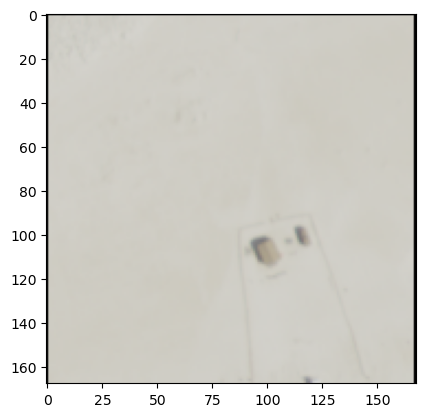

In [237]:
import matplotlib.pyplot as plt
import numpy as np

img = np.dstack((image_rgbir[0], image_rgbir[1], image_rgbir[2]))

plt.imshow(img)

## Crop in pixels to make sure no weird boundaries happen

In [238]:
import operator

def cropCenter(img, bounding):
    start = tuple(map(lambda a, da: a//2-da//2, img.shape, bounding))
    end = tuple(map(operator.add, start, bounding))
    slices = tuple(map(slice, start, end))
    return img[slices]

In [269]:
WINDOW_SIZE_PX = 5

assert (WINDOW_SIZE_PX < image_rgbir.shape[1])

((5, 5, 3), (4, 5, 5))

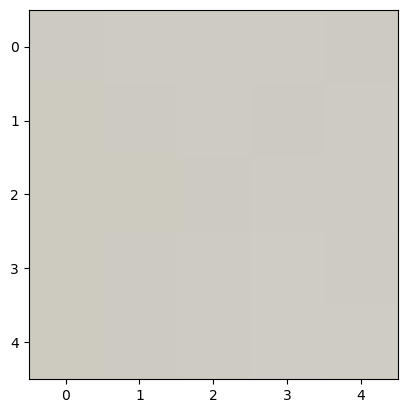

In [270]:
img_rgbir_crop = cropCenter(image_rgbir, (4,WINDOW_SIZE_PX,WINDOW_SIZE_PX))
img_crop_viz = np.dstack((img_rgbir_crop[0], img_rgbir_crop[1], img_rgbir_crop[2]))

plt.imshow(img_crop_viz)
img_crop_viz.shape, img_rgbir_crop.shape

# GLCM Feature Extraction

## First convert to grayscale

Version1 : average all bands

array([[195, 195, 196, 195, 195],
       [195, 195, 195, 195, 196],
       [194, 195, 195, 196, 196],
       [194, 195, 196, 196, 196],
       [194, 195, 196, 197, 197]], dtype=uint8)

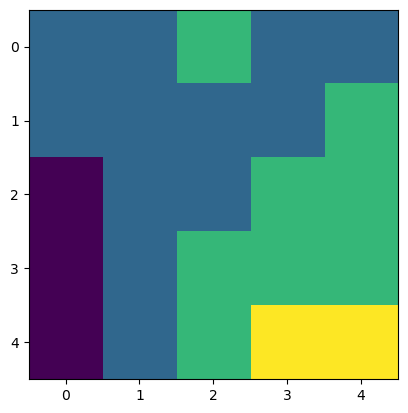

In [271]:
gray1 = np.average(img_rgbir_crop, axis=0).astype('uint8')
display(gray1)
plt.imshow(gray1)

Version 2

Equation taken from "Experimental analysis of sand grain size mapping using UAV remote sensing" - Bae et. al 2019

array([[201, 202, 202, 202, 202],
       [201, 202, 202, 202, 202],
       [201, 201, 202, 202, 203],
       [201, 201, 202, 203, 203],
       [201, 201, 203, 203, 203]], dtype=uint8)

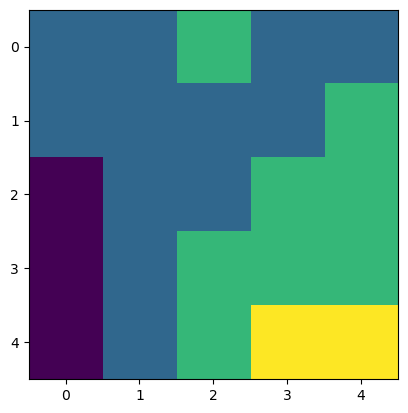

In [272]:
gray2 = np.average(img_rgbir_crop, axis=0, weights=[0.3, 0.59, 0.11, 0.]).astype('uint8')
display(gray2)
plt.imshow(gray1)

Marchetti et. al (2021), and Black et. al (2014) both used a range of 33, 51 and 101 kernel window size. For a 2cm/px resolution this roughly equates to 0.6m, 1m and 2m
For a 0.6m/px resolution (NAIP), this roughly equates to 1, 2 and 3px respectively

In [279]:
glcm1 = graycomatrix(gray1, distances=[1,2,3], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256,
                        symmetric=True, normed=False)
glcm2 = graycomatrix(gray2, distances=[1,2,3], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256,
                        symmetric=True, normed=False)

In [280]:
dis1, dis2 = graycoprops(glcm1, 'dissimilarity'), graycoprops(glcm2, 'dissimilarity')

Average the directional values, but keep the offsets?

In [254]:
np.average(dis1, axis=1)

array([1.06973761, 1.41640853, 4.90744055])

In [281]:
np.average(dis1, axis=1)

array([0.478125  , 0.665625  , 0.91666667])

In [282]:
hom1, hom2 = graycoprops(glcm1, 'homogeneity'), graycoprops(glcm2, 'homogeneity')

In [283]:
np.average(hom1, axis=1)

array([0.7609375 , 0.6771875 , 0.59888889])

In [284]:
graycoprops(glcm1, 'homogeneity'), graycoprops(glcm2, 'homogeneity')

(array([[0.75      , 0.65625   , 0.825     , 0.8125    ],
        [0.57333333, 0.65625   , 0.66666667, 0.8125    ],
        [0.52      , 0.51111111, 0.62      , 0.74444444]]),
 array([[0.81      , 0.7625    , 0.9       , 0.84375   ],
        [0.60666667, 0.7625    , 0.76666667, 0.84375   ],
        [0.45      , 0.48888889, 0.65      , 0.66666667]]))

In [201]:
graycoprops(glcm1, 'correlation'), graycoprops(glcm2, 'correlation')

(array([[0.83997342, 0.81546982, 0.83997342, 0.78860864],
        [0.57552922, 0.56364951, 0.57552922, 0.57868155],
        [0.35362115, 0.45170162, 0.35362115, 0.42805627]]),
 array([[0.78412023, 0.69421195, 0.78412023, 0.6724742 ],
        [0.47387806, 0.40706961, 0.47387806, 0.44100117],
        [0.31314112, 0.29074111, 0.31314112, 0.29938078]]))

In [202]:
graycoprops(glcm1, 'contrast'), graycoprops(glcm2, 'contrast')

(array([[19.23012301, 22.76587659, 19.23012301, 25.61737374],
        [49.4964934 , 53.36592409, 49.4964934 , 49.78850359],
        [72.91415515, 67.94625177, 72.91415515, 65.68036685]]),
 array([[ 8.5339534 , 11.99919992,  8.5339534 , 12.80767677],
        [20.83941832, 22.88242574, 20.83941832, 21.44923461],
        [27.30878033, 27.8539876 , 27.30878033, 27.18851902]]))

In [203]:
graycoprops(glcm1, 'energy'), graycoprops(glcm2, 'energy')

(array([[0.12949347, 0.13072891, 0.12949347, 0.12991075],
        [0.12221552, 0.12068431, 0.12221552, 0.12345767],
        [0.11460225, 0.11161909, 0.11460225, 0.11751046]]),
 array([[0.21521808, 0.21871392, 0.21521808, 0.21764814],
        [0.19830012, 0.19690465, 0.19830012, 0.20568737],
        [0.1853504 , 0.18241216, 0.1853504 , 0.19629454]]))

# Closing Notes

To do the equivalent of what [ee.Image.glcmTexture](https://developers.google.com/earth-engine/apidocs/ee-image-glcmtexture) does in GEE, i.e. use a sliding window to compute the texture features for the entire masked sandy areas, follow [this post](https://stackoverflow.com/questions/42459493/sliding-window-in-python-for-glcm-calculation)

Also check [this out](https://stackoverflow.com/questions/35551249/implementing-glcm-texture-feature-with-scikit-image-and-python)